In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from numpy import sort
from sklearn.feature_selection import SelectFromModel


# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [ ]:
df=pd.read_csv('adult_income.csv')
df.drop_duplicates(keep='first',inplace=True)
df.drop(index=df[(df[' Work-class']==' ?')|(df[' Occupation']==' ?') |(df[' Native-country']==' ?')].index,inplace=True)
df['income']=df[' Income'].map(lambda x: 0 if x ==' <=50K' else 1)
df.drop(" Income",axis=1,inplace=True)
print(df.shape)

(30139, 15)


In [ ]:
# One-hot Encoding for categorical data (native-country 0 for US,1 for others)
df=pd.get_dummies(df, columns=[' Work-class'],drop_first=False)
df=pd.get_dummies(df, columns=[' Marital-status'],drop_first=False)
df=pd.get_dummies(df, columns=[' Occupation'],drop_first=False)
df=pd.get_dummies(df, columns=[' Relationship'],drop_first=False)
df=pd.get_dummies(df, columns=[' Race'],drop_first=False)
df=pd.get_dummies(df, columns=[' Sex'],drop_first=False)
df[' Native-country']=df[' Native-country'].map(lambda x: 0 if x ==' United-States' else 1)

In [ ]:
# Eduction and Eduction_num are essentially duplicate
df.drop(' Education', axis=1, inplace=True)

In [ ]:
#Combine Capitcal columns together
print(df.shape)
df['Capital'] = df[' Capital-gain'] + df[' Capital-loss']
df.drop(' Capital-gain', axis=1, inplace=True)
df.drop(' Capital-loss', axis=1, inplace=True)
print(df.shape)

(30139, 49)
(30139, 48)


In [ ]:
# drop the outliers of captical and trying to protect data integrity
index=df[df['Capital']>=10000].index
df.drop(index=index,inplace=True)
df.shape

In [ ]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df[[' fnlwgt','Capital',' Hours-per-week']])
df[[' fnlwgt','Capital',' Hours-per-week']] = scaler.transform(df[[' fnlwgt','Capital',' Hours-per-week']])

# PCA

In [ ]:
dataX=df.drop('income',axis=1)
dataY=df['income']

In [ ]:
variance_explained = 0.95
pca = PCA(variance_explained)
principalComponents = pca.fit(dataX)
print(principalComponents.explained_variance_ratio_)
principalComponents = principalComponents.transform(dataX)

[0.93122718 0.03496091]


In [ ]:
principalDf = pd.DataFrame(data = principalComponents)
# # Concatenate dataframe with 'shares_bin2' column
df_pca = pd.merge(principalDf, df[['income']].reset_index(drop='index'),right_index=True,left_index=True)
df_pca

,0,1,income
0,0.781,-3.015,0
1,11.794,-2.747,0
2,-0.247,1.095,0
3,14.751,3.198,0
4,-10.220,-2.971,0
...,...,...,...
29402,-16.259,-0.012,0
29403,-11.223,-1.970,0
29404,1.777,1.086,1
29405,19.742,1.248,0


## Comparison

In [ ]:
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import xgboost
import lightgbm as lgb


In [ ]:
def model(X_train, X_test, y_train, y_test):
    models = {'knn': KNeighborsClassifier(),
            'lr':linear_model.LogisticRegression(random_state=123),
            'rf':ensemble.RandomForestClassifier(random_state=123),
            'xgboost':xgboost.XGBClassifier(random_state=123),
            'lighGBM':lgb.LGBMClassifier(random_state=123)
            }

    y_predicts = pd.DataFrame()
    for name, model in models.items():
        clf = model.fit(X_train, y_train)
        y_train_pred = clf.predict_proba(X_train)
        auc = metrics.roc_auc_score(y_train, y_train_pred[:,1])
        print('Model: {} | train AUC: {:.4f}'.format(name, auc))
        y_test_pred = clf.predict_proba(X_test) 
        auc_test = metrics.roc_auc_score(y_test, y_test_pred[:,1])
        print('Test: Model: {} | Test AUC: {:.4f}'.format(name, auc_test))
        y_predicts.loc[name,'train AUC']=auc
        y_predicts.loc[name,'test AUC']=auc_test
    return y_predicts

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY,
                                                    stratify=dataY, 
                                                  random_state=2017, 
                                                  test_size=0.3, shuffle=True)

In [ ]:
result_no=model(x_train, x_test, y_train, y_test)

Model: knn | train AUC: 0.9378
Test: Model: knn | Test AUC: 0.8463


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: lr | train AUC: 0.8947
Test: Model: lr | Test AUC: 0.8928
Model: rf | train AUC: 1.0000
Test: Model: rf | Test AUC: 0.8903


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: xgboost | train AUC: 0.9628
Test: Model: xgboost | Test AUC: 0.9157


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: lighGBM | train AUC: 0.9458
Test: Model: lighGBM | Test AUC: 0.9181


In [ ]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(df_pca.drop('income',axis=1), df_pca['income'],
                                                    stratify=df_pca['income'], 
                                                  random_state=2017, 
                                                  test_size=0.3, shuffle=True)

In [ ]:
result_pca=model(x_train_pca, x_test_pca, y_train_pca, y_test_pca)

Model: knn | train AUC: 0.9167
Test: Model: knn | Test AUC: 0.7934
Model: lr | train AUC: 0.7727
Test: Model: lr | Test AUC: 0.7641
Model: rf | train AUC: 1.0000
Test: Model: rf | Test AUC: 0.8195


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: xgboost | train AUC: 0.9228
Test: Model: xgboost | Test AUC: 0.8427


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Model: lighGBM | train AUC: 0.8804
Test: Model: lighGBM | Test AUC: 0.8444


In [ ]:
result_pca['methods']='pca'
result_no['methods']='baseline'
merge=pd.concat([result_no,result_pca])
merge.reset_index(inplace=True)
merge.rename(columns={'index':'model'},inplace=True)

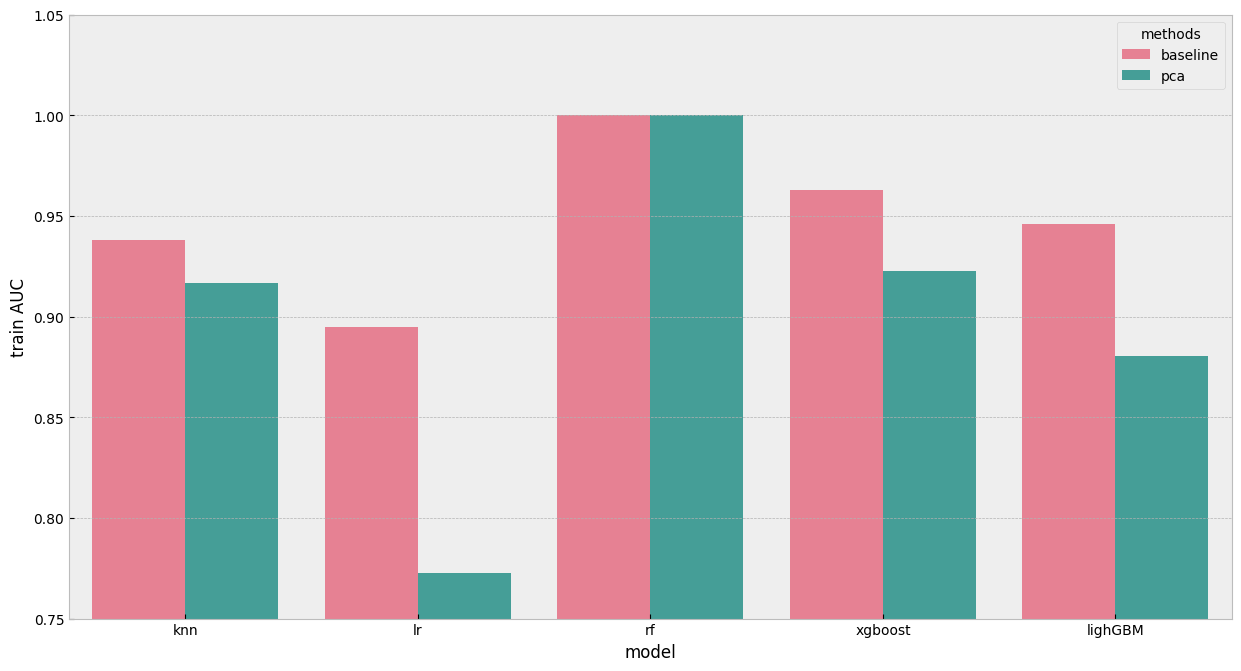

In [ ]:
plt.figure(figsize=(15,8),dpi=100)
sns.barplot( x='model',y="train AUC", hue="methods", data=merge,capsize=.05,palette="husl")
plt.ylim([0.75,1.05])
plt.show()

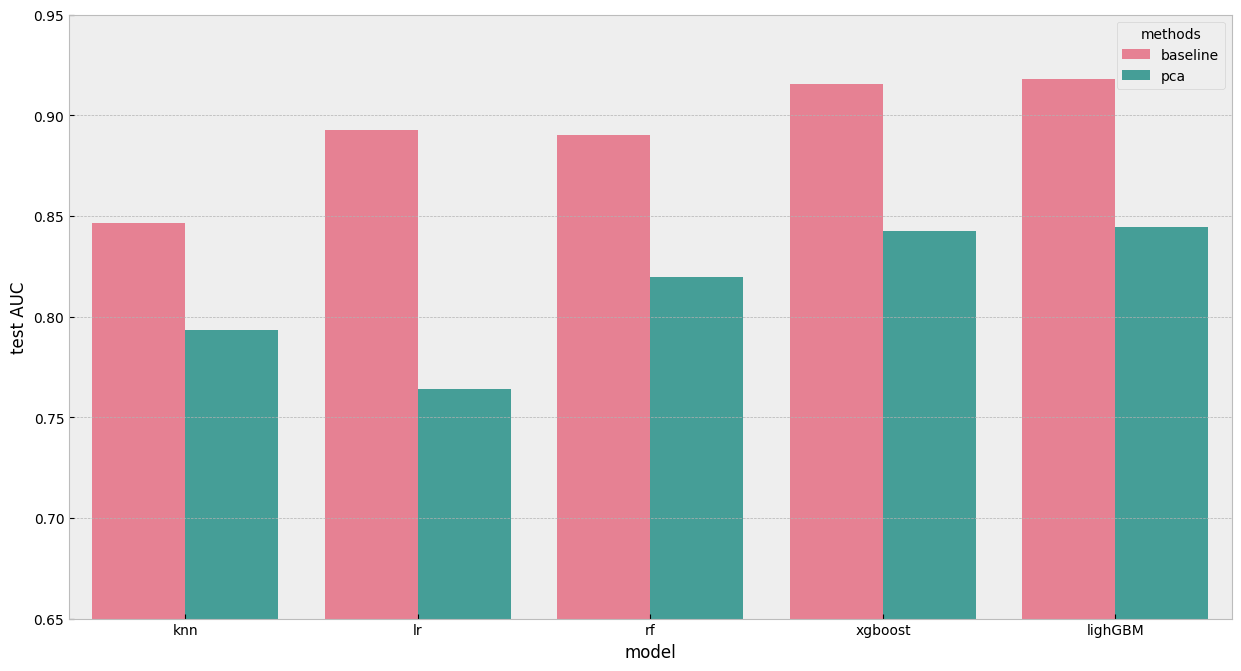

In [ ]:
plt.figure(figsize=(15,8),dpi=100)
sns.barplot( x='model',y="test AUC", hue="methods", data=merge,capsize=.05,palette="husl")
plt.ylim([0.65,0.95])
plt.show()

# Model building

## Find suitable methods to deal with imbalanced data


In [ ]:
X=df.drop('income',axis=1)
y=df['income']

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
# Apply the random under-sampling
rus = RandomUnderSampler()
X_RUS, y_RUS = rus.fit_resample(X, y)
# Apply the random over-sampling
ros = RandomOverSampler()
X_ROS, y_ROS = ros.fit_resample(X, y)
# Apply regular SMOTE
sm = SMOTE()
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)

X_RUS_train, X_RUS_test, y_RUS_train, y_RUS_test = train_test_split(X_RUS, y_RUS, test_size=0.3, random_state=2017)
X_ROS_train, X_ROS_test, y_ROS_train, y_ROS_test = train_test_split(X_ROS, y_ROS, test_size=0.3, random_state=2017)
X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.3, random_state=2017)

In [ ]:
clf = lgb.LGBMClassifier(objective='binary',random_state=123)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_ros = clf.fit(X_ROS_train, y_ROS_train) 
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)
# Evaluate model performance
print ("\nRUS - Train AUC : ",metrics.roc_auc_score(y_RUS_train, clf.predict_proba(X_RUS_train)[:,1]))
print ("RUS - Test AUC : ",metrics.roc_auc_score(y_RUS_test, clf.predict_proba(X_RUS_test)[:,1]))
print ("\nROS - Train AUC : ",metrics.roc_auc_score(y_ROS_train, clf.predict_proba(X_ROS_train)[:,1]))
print ("ROS - Test AUC : ",metrics.roc_auc_score(y_ROS_test, clf.predict_proba(X_ROS_test)[:,1]))
print ("\nSMOTE - Train AUC : ",metrics.roc_auc_score(y_SMOTE_train, clf.predict_proba(X_SMOTE_train)[:,1]))
print ("SMOTE - Test AUC : ",metrics.roc_auc_score(y_SMOTE_test, clf.predict_proba(X_SMOTE_test)[:,1]))


RUS - Train AUC :  0.9267501828254847
RUS - Test AUC :  0.9211062370455572

ROS - Train AUC :  0.9287443289485932
ROS - Test AUC :  0.9220175539737682

SMOTE - Train AUC :  0.9713159546578004
SMOTE - Test AUC :  0.9664389092746485


In [ ]:
clf = linear_model.LogisticRegression(random_state=123)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_ros = clf.fit(X_ROS_train, y_ROS_train) 
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)
# Evaluate model performance
print ("\nRUS - Train AUC : ",metrics.roc_auc_score(y_RUS_train, clf.predict_proba(X_RUS_train)[:,1]))
print ("RUS - Test AUC : ",metrics.roc_auc_score(y_RUS_test, clf.predict_proba(X_RUS_test)[:,1]))
print ("\nROS - Train AUC : ",metrics.roc_auc_score(y_ROS_train, clf.predict_proba(X_ROS_train)[:,1]))
print ("ROS - Test AUC : ",metrics.roc_auc_score(y_ROS_test, clf.predict_proba(X_ROS_test)[:,1]))
print ("\nSMOTE - Train AUC : ",metrics.roc_auc_score(y_SMOTE_train, clf.predict_proba(X_SMOTE_train)[:,1]))
print ("SMOTE - Test AUC : ",metrics.roc_auc_score(y_SMOTE_test, clf.predict_proba(X_SMOTE_test)[:,1]))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


RUS - Train AUC :  0.8875207091412741
RUS - Test AUC :  0.877338071877135

ROS - Train AUC :  0.8851122102349254
ROS - Test AUC :  0.8879110745159042

SMOTE - Train AUC :  0.9361338911096526
SMOTE - Test AUC :  0.9346778814762605


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
clf = XGBClassifier(random_state=123)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_ros = clf.fit(X_ROS_train, y_ROS_train) 
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)
# Evaluate model performance
print ("\nRUS - Train AUC : ",metrics.roc_auc_score(y_RUS_train, clf.predict_proba(X_RUS_train)[:,1]))
print ("RUS - Test AUC : ",metrics.roc_auc_score(y_RUS_test, clf.predict_proba(X_RUS_test)[:,1]))
print ("\nROS - Train AUC : ",metrics.roc_auc_score(y_ROS_train, clf.predict_proba(X_ROS_train)[:,1]))
print ("ROS - Test AUC : ",metrics.roc_auc_score(y_ROS_test, clf.predict_proba(X_ROS_test)[:,1]))
print ("\nSMOTE - Train AUC : ",metrics.roc_auc_score(y_SMOTE_train, clf.predict_proba(X_SMOTE_train)[:,1]))
print ("SMOTE - Test AUC : ",metrics.roc_auc_score(y_SMOTE_test, clf.predict_proba(X_SMOTE_test)[:,1]))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



RUS - Train AUC :  0.9416991468144045
RUS - Test AUC :  0.9396031067503985


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



ROS - Train AUC :  0.9482962622337356
ROS - Test AUC :  0.9270879516144198


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



SMOTE - Train AUC :  0.9811065367286692
SMOTE - Test AUC :  0.9660262794986427


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### SMOTE shows the best


In [ ]:
def confusion(model, X_test, y_test):
    plt.figure(figsize=(15,10),dpi=200)
    metrics.plot_confusion_matrix(model, X_test, y_test,
                                  display_labels=np.unique(y_test),
                                  #include_values=False,
                                  values_format = 'd',
                                  cmap=plt.cm.Blues)
    plt.show()

In [ ]:
def report(model,X_test,y_test):
    roc_auc_score = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    accuracy_score = metrics.accuracy_score(y_test, model.predict(X_test))
    f1_score = metrics.f1_score(y_test, model.predict(X_test), average=None)
    precision_score = metrics.precision_score(y_test,model.predict(X_test), average=None)
    print('ROC AUC score:', roc_auc_score)
    print('Accuracy score:', accuracy_score)
    print('F1 score:', f1_score)
    print('Precision score:', precision_score)

    print("Classification report for classifier %s:\n%s\n"
    % (model, metrics.classification_report(y_test, model.predict(X_test))))

In [ ]:
def feature_importance(model):

    df_importance = pd.DataFrame()
    df_importance['importance'] = model.feature_importances_
    df_importance['features'] = df.drop('income',axis=1).columns
    df_importance = df_importance.sort_values(by='importance', ascending=False) 
    df_importance = df_importance.reset_index(drop=True)
    
    return df_importance

# Training 3 best models

## LightGBM

In [ ]:
# use SMOTE only for train dataset
sm_new=SMOTE()
X_SMOTE_train, y_SMOTE_train = sm_new.fit_resample(x_train, y_train)
print(y_SMOTE_train.value_counts())
print(y_test.value_counts())

0    15834
1    15834
Name: income, dtype: int64
0    6787
1    2036
Name: income, dtype: int64


In [ ]:
model_lightGBM = lgb.LGBMClassifier(random_state=123)
model_lightGBM.fit(X_SMOTE_train, y_SMOTE_train)
y_SMOTE_pred=model_lightGBM.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=model_lightGBM.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='lightGBM'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

Train: Model: lightGBM | Train AUC: 0.9740
Test: Model: lightGBM | Test AUC: 0.9114


In [ ]:
report(model_lightGBM,x_test,y_test)

ROC AUC score: 0.9113867361125785
Accuracy score: 0.8563980505496996
F1 score: [0.90591817 0.69681742]
Precision score: [0.91317365 0.67942137]
Classification report for classifier LGBMClassifier(random_state=123):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6787
           1       0.68      0.72      0.70      2036

    accuracy                           0.86      8823
   macro avg       0.80      0.81      0.80      8823
weighted avg       0.86      0.86      0.86      8823




/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x2000 with 0 Axes>

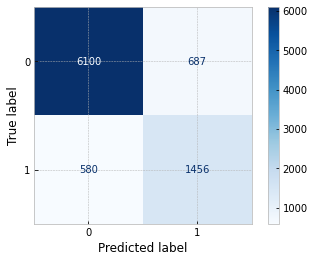

In [ ]:
confusion(model_lightGBM,x_test,y_test)

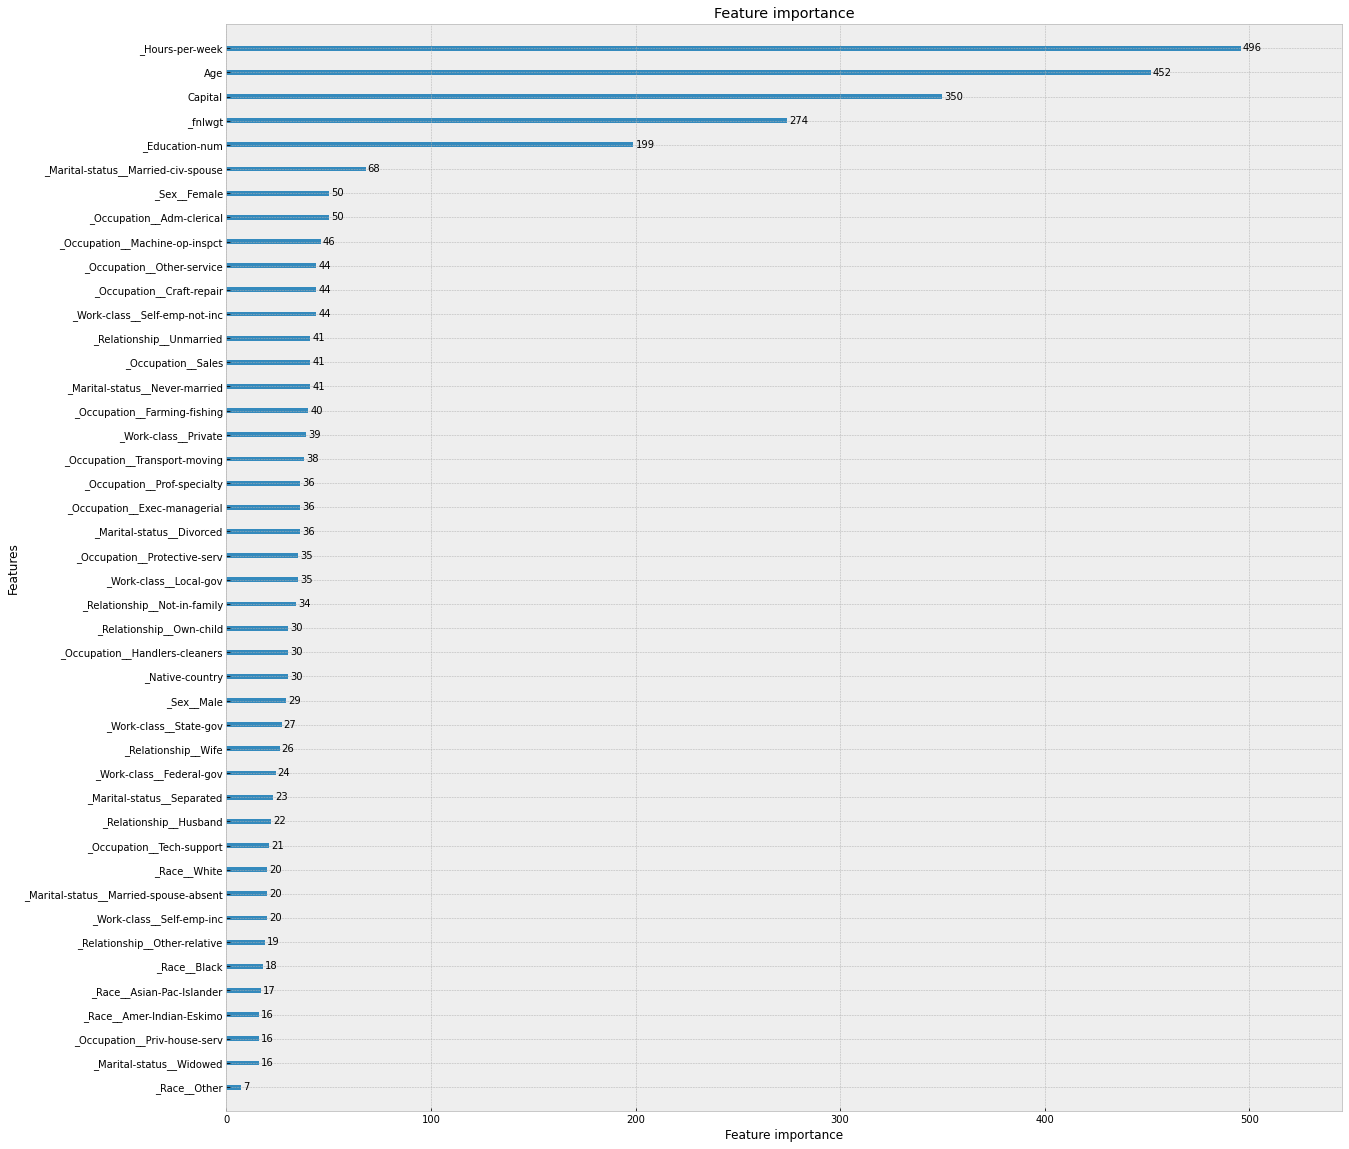

In [ ]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(20,20))
plot_importance(model_lightGBM, ax=ax)
plt.show()

In [ ]:
feature_importance(model_lightGBM)

,importance,features
0,496,Hours-per-week
1,452,Age
2,350,Capital
3,274,fnlwgt
4,199,Education-num
5,68,Marital-status_ Married-civ-spouse
6,50,Sex_ Female
7,50,Occupation_ Adm-clerical
8,46,Occupation_ Machine-op-inspct
9,44,Work-class_ Self-emp-not-inc


## Logistics Regression

In [ ]:
model_lr = linear_model.LogisticRegression(random_state=123)
model_lr.fit(X_SMOTE_train, y_SMOTE_train)
y_SMOTE_pred=model_lr.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=model_lr.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='lrmodel'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

Train: Model: lrmodel | Train AUC: 0.9361
Test: Model: lrmodel | Test AUC: 0.8864


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
report(model_lr,x_test,y_test)

ROC AUC score: 0.8863990965045565
Accuracy score: 0.8160489629377763
F1 score: [0.87477818 0.65357524]
Precision score: [0.91820538 0.57795394]
Classification report for classifier LogisticRegression(random_state=123):
              precision    recall  f1-score   support

           0       0.92      0.84      0.87      6787
           1       0.58      0.75      0.65      2036

    accuracy                           0.82      8823
   macro avg       0.75      0.79      0.76      8823
weighted avg       0.84      0.82      0.82      8823




/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x2000 with 0 Axes>

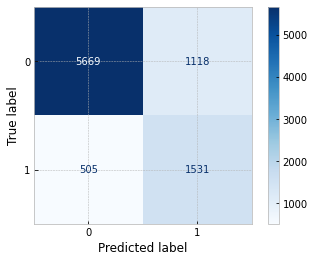

In [ ]:
confusion(model_lr,x_test,y_test)

## XGBoost

In [ ]:
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_SMOTE_train, y_SMOTE_train)
y_SMOTE_pred=model_xgb.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=model_xgb.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='XGBoost'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Train: Model: XGBoost | Train AUC: 0.9836
Test: Model: XGBoost | Test AUC: 0.9063


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
report(model_xgb,x_test,y_test)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


ROC AUC score: 0.9063475606173017
Accuracy score: 0.8511844043975972
F1 score: [0.90253136 0.68550898]
Precision score: [0.90948534 0.66900421]
Classification report for classifier XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None):
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6787
           1       0.67      0.70      0.69      2036

    accuracy                           0.85      8823
   macro avg    

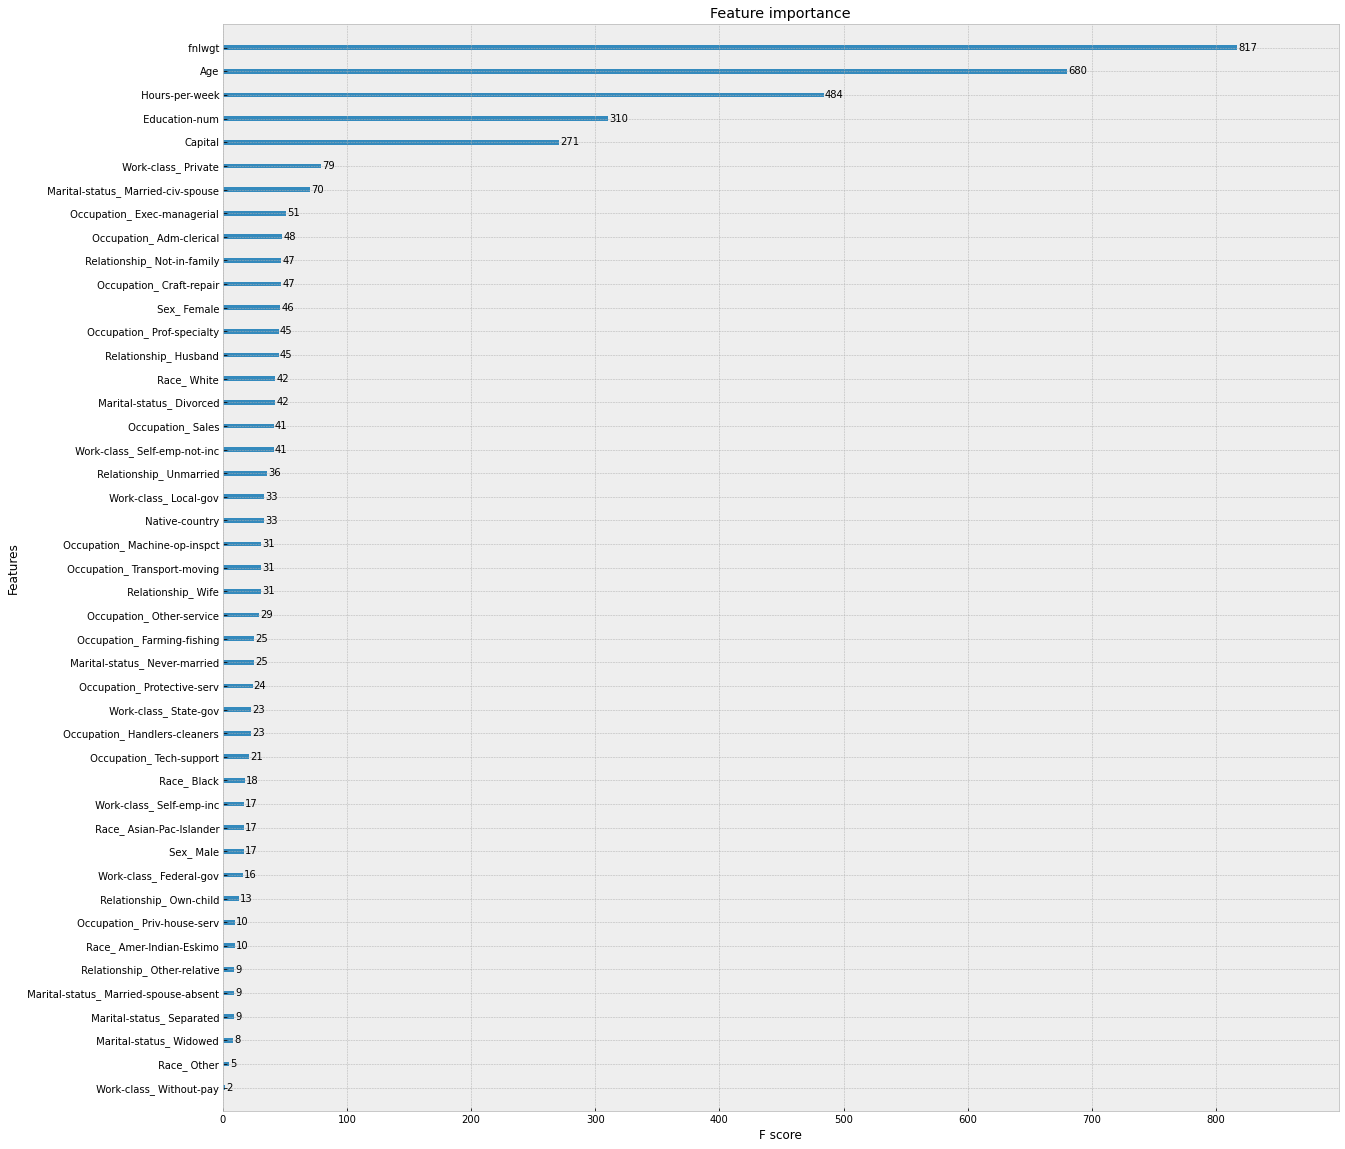

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(20,20))
plot_importance(model_xgb, ax=ax). # the impportance type is default : based on 'weight', means the times this feature shows trees
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<Figure size 3000x2000 with 0 Axes>

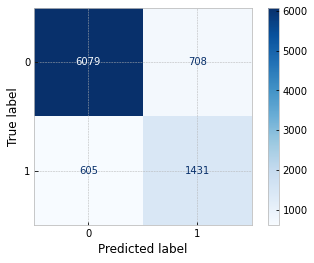

In [ ]:
confusion(model_xgb,x_test,y_test)

# Tuning LightGBM

In [ ]:
#set estimator
estimator = lgb.LGBMClassifier(random_state=123)

#set parameter
parameters = {
                'num_leaves':[31],
                'max_depth':[20],
                'feature_fraction':[0.78],
                'min_gain_to_split':[1],
                'learning_rate':[0.1],
                'num_iterations':[100,150],
                'max_bin':[300]
                }

#configure the GridSearchCV object
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=True)

# fit the model
grid_search.fit(X_SMOTE_train, y_SMOTE_train)
print(grid_search.best_params_)
best=grid_search.best_estimator_

y_SMOTE_pred=best.predict_proba(X_SMOTE_train)
train_auc = metrics.roc_auc_score(y_SMOTE_train, y_SMOTE_pred[:,1])
y_pred=best.predict_proba(x_test)
test_auc = metrics.roc_auc_score(y_test, y_pred[:,1])
name='lightGBM'
print('Train: Model: {} | Train AUC: {:.4f}'.format(name, train_auc))
print('Test: Model: {} | Test AUC: {:.4f}'.format(name, test_auc))

dictl[str(grid_search.best_params_)]=test_auc

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
{'feature_fraction': 1, 'learning_rate': 0.1, 'max_bin': 300, 'max_depth': 20, 'min_gain_to_split': 1, 'num_iterations': 150, 'num_leaves': 31}
Train: Model: lightGBM | Train AUC: 0.9770
Test: Model: lightGBM | Test AUC: 0.9122


In [ ]:
feature_importance(best)

,importance,features
0,788,Hours-per-week
1,666,Age
2,609,fnlwgt
3,521,Capital
4,309,Education-num
5,62,Occupation_ Adm-clerical
6,58,Occupation_ Machine-op-inspct
7,58,Occupation_ Craft-repair
8,54,Occupation_ Other-service
9,52,Occupation_ Transport-moving


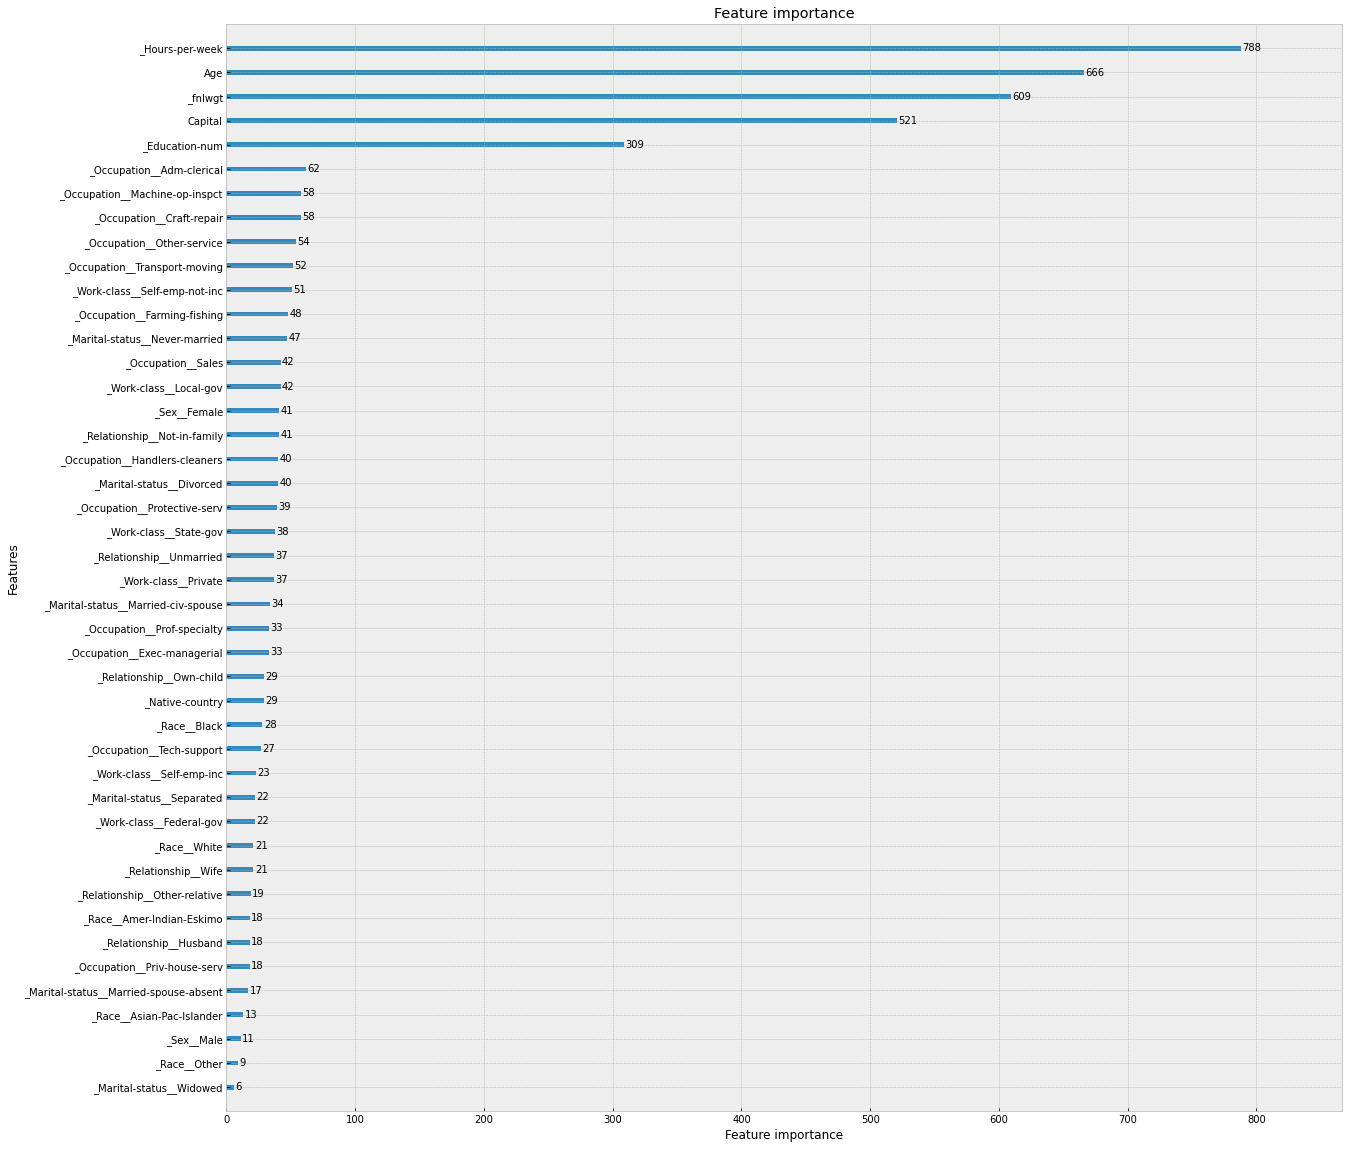

In [ ]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(20,20))
plot_importance(best, ax=ax)
plt.show()

In [ ]:
report(best,x_test,y_test)

ROC AUC score: 0.91222772039346
Accuracy score: 0.8579848124220787
F1 score: [0.90695775 0.7001675 ]
Precision score: [0.91422156 0.68268782]
Classification report for classifier LGBMClassifier(max_bin=300, max_depth=20, min_gain_to_split=1,
               num_iterations=150, random_state=123):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6787
           1       0.68      0.72      0.70      2036

    accuracy                           0.86      8823
   macro avg       0.80      0.81      0.80      8823
weighted avg       0.86      0.86      0.86      8823




/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x2000 with 0 Axes>

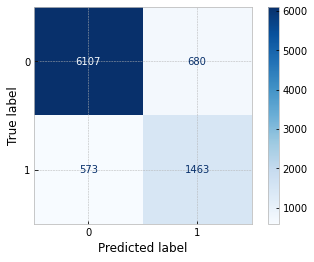

In [ ]:
confusion(best,x_test,y_test)